In [1]:
using HDF5
# using JLD
using Knet
# using IterTools: ncycle

In [2]:
function read_data(datafile, namelist, dims)
    sz = length(namelist)
    data = Array(zeros(Float32, dims..., sz))
    fid = h5open(datafile)
    @inbounds for i = 1:sz
        input = read(fid, convert(String, namelist[i]))
        data[:, :, :, :, i] = input
    end
    close(fid)
    data_gpu = ka(data)
    return data_gpu
end

read_data (generic function with 1 method)

In [3]:
function read_namelist(file)#y
    #Reading the list of protein names from the given file name
    text = readlines(file)
    text = [split(i) for i in text]
    labels = zeros(Int32,length(text))
    for i in 1:length(text)
        labels[i] = parse(Int32, text[i][2]) + 1 # 1 ->0, 2->1
    end
    return [i[1] for i in text], labels
end

read_namelist (generic function with 1 method)

In [4]:
# Convolutional layer:
struct Conv; w; b; f; end
(c::Conv)(x) = c.f.(pool(conv4(c.w, x) .+ c.b))
Conv(w1,w2,w3,cx,cy,f=relu) = Conv(param(w1,w2,w3,cx,cy), param0(1,1,1,cy,1), f)

# Dense layer:
struct Dense; w; b; f; end
(d::Dense)(x) = d.f.(d.w * mat(x) .+ d.b)
Dense(i::Int,o::Int,f=relu) = Dense(param(o,i), param0(o), f)

# A chain of layers and a loss function:
struct Chain; layers; end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)

LeNet = Chain((Conv(5,5,5,40,50), Conv(5,5,5,50,60), Dense(1620,920), Dense(920,2,identity)));

In [14]:
data_path = "/scratch/users/ekucuk19/workfolder/Cosbilab/emre_deepinterface/interactome_data/data/deepinter_data.h5";
vallist, vallabels = read_namelist("/scratch/users/ekucuk19/workfolder/Cosbilab/emre_deepinterface/interactome_data/data/val_scrambled_2.txt");
trnlist, trnlabels = read_namelist("/scratch/users/ekucuk19/workfolder/Cosbilab/emre_deepinterface/interactome_data/data/train_scrambled_2.txt");
# tstlist, tstlabels = read_namelist("/scratch/users/ekucuk19/workfolder/Cosbilab/emre_deepinterface/interactome_data/data/test_scrambled_2.txt");

In [10]:
dtrn = minibatch(trnlist, trnlabels, 100)
dval = minibatch(vallist, vallabels, 100)
# dtst = minibatch(tstlist, tstlabels, 100)

Knet.Data{Tuple{Array{SubString{String},1},Array{Int32,1}}}(SubString{String}["3QI3AB" "3FCPAC" … "1DZMAB" "2J0ZCD"], Int32[2 2 … 2 2], 100, 127790, false, 127691, 1:127790, false, (127790,), (127790,), Array{SubString{String},1}, Array{Int32,1})

In [9]:
val_acc_history = Array{Float64,1}()
trn_acc_history = Array{Float64,1}()
for (index,(names,labels)) in enumerate(dtrn)
    data = read_data(data_path,names,(25,25,25,40));
    sgd!(LeNet, [(data, labels)])
    if index%100 == 0
        println("Validation starts.")
        counter = 0;
        val_acc = 0;
        for (names,labels) in dval
            val_data = read_data(data_path,names,(25,25,25,40))
            counter += 1
            val_acc += accuracy(LeNet(val_data),labels)
        end     
        avg_val_acc = val_acc/counter
        push!(val_acc_history, avg_val_acc)
        println(avg_val_acc)
        println("End of validation.")
    end
    minibatch_err = accuracy(LeNet(data),labels)
    push!(trn_acc_history, minibatch_err)
    println("Iter:$(index)/2555, Progress:%$((index*100)/2555), Iter Acc:$(minibatch_err)")
end

Iter:1/2555, Progress:%0.03913894324853229, Iter Acc:0.5
Iter:2/2555, Progress:%0.07827788649706457, Iter Acc:0.51
Iter:3/2555, Progress:%0.11741682974559686, Iter Acc:0.52
Iter:4/2555, Progress:%0.15655577299412915, Iter Acc:0.55
Iter:5/2555, Progress:%0.19569471624266144, Iter Acc:0.55
Iter:6/2555, Progress:%0.23483365949119372, Iter Acc:0.59
Iter:7/2555, Progress:%0.273972602739726, Iter Acc:0.58
Iter:8/2555, Progress:%0.3131115459882583, Iter Acc:0.54
Iter:9/2555, Progress:%0.3522504892367906, Iter Acc:0.62
Iter:10/2555, Progress:%0.3913894324853229, Iter Acc:0.58
Iter:11/2555, Progress:%0.43052837573385516, Iter Acc:0.59
Iter:12/2555, Progress:%0.46966731898238745, Iter Acc:0.69
Iter:13/2555, Progress:%0.5088062622309197, Iter Acc:0.66
Iter:14/2555, Progress:%0.547945205479452, Iter Acc:0.64
Iter:15/2555, Progress:%0.5870841487279843, Iter Acc:0.68
Iter:16/2555, Progress:%0.6262230919765166, Iter Acc:0.57
Iter:17/2555, Progress:%0.6653620352250489, Iter Acc:0.73
Iter:18/2555, Prog

Iter:143/2555, Progress:%5.596868884540117, Iter Acc:0.72
Iter:144/2555, Progress:%5.636007827788649, Iter Acc:0.71
Iter:145/2555, Progress:%5.675146771037182, Iter Acc:0.67
Iter:146/2555, Progress:%5.714285714285714, Iter Acc:0.73
Iter:147/2555, Progress:%5.7534246575342465, Iter Acc:0.74
Iter:148/2555, Progress:%5.7925636007827785, Iter Acc:0.76
Iter:149/2555, Progress:%5.8317025440313115, Iter Acc:0.51
Iter:150/2555, Progress:%5.870841487279844, Iter Acc:0.54
Iter:151/2555, Progress:%5.909980430528376, Iter Acc:0.53
Iter:152/2555, Progress:%5.949119373776908, Iter Acc:0.45
Iter:153/2555, Progress:%5.988258317025441, Iter Acc:0.66
Iter:154/2555, Progress:%6.027397260273973, Iter Acc:0.7
Iter:155/2555, Progress:%6.066536203522505, Iter Acc:0.77
Iter:156/2555, Progress:%6.105675146771037, Iter Acc:0.71
Iter:157/2555, Progress:%6.14481409001957, Iter Acc:0.74
Iter:158/2555, Progress:%6.183953033268102, Iter Acc:0.69
Iter:159/2555, Progress:%6.223091976516634, Iter Acc:0.73
Iter:160/2555

Iter:284/2555, Progress:%11.11545988258317, Iter Acc:0.72
Iter:285/2555, Progress:%11.154598825831702, Iter Acc:0.71
Iter:286/2555, Progress:%11.193737769080235, Iter Acc:0.57
Iter:287/2555, Progress:%11.232876712328768, Iter Acc:0.7
Iter:288/2555, Progress:%11.272015655577299, Iter Acc:0.68
Iter:289/2555, Progress:%11.311154598825832, Iter Acc:0.78
Iter:290/2555, Progress:%11.350293542074365, Iter Acc:0.75
Iter:291/2555, Progress:%11.389432485322896, Iter Acc:0.7
Iter:292/2555, Progress:%11.428571428571429, Iter Acc:0.79
Iter:293/2555, Progress:%11.46771037181996, Iter Acc:0.78
Iter:294/2555, Progress:%11.506849315068493, Iter Acc:0.71
Iter:295/2555, Progress:%11.545988258317026, Iter Acc:0.74
Iter:296/2555, Progress:%11.585127201565557, Iter Acc:0.79
Iter:297/2555, Progress:%11.62426614481409, Iter Acc:0.76
Iter:298/2555, Progress:%11.663405088062623, Iter Acc:0.77
Iter:299/2555, Progress:%11.702544031311154, Iter Acc:0.67
Validation starts.
0.7050828729281771
End of validation.
Iter

Iter:422/2555, Progress:%16.516634050880626, Iter Acc:0.74
Iter:423/2555, Progress:%16.555772994129157, Iter Acc:0.69
Iter:424/2555, Progress:%16.59491193737769, Iter Acc:0.74
Iter:425/2555, Progress:%16.634050880626223, Iter Acc:0.74
Iter:426/2555, Progress:%16.673189823874754, Iter Acc:0.7
Iter:427/2555, Progress:%16.71232876712329, Iter Acc:0.73
Iter:428/2555, Progress:%16.75146771037182, Iter Acc:0.73
Iter:429/2555, Progress:%16.79060665362035, Iter Acc:0.75
Iter:430/2555, Progress:%16.829745596868886, Iter Acc:0.76
Iter:431/2555, Progress:%16.868884540117417, Iter Acc:0.61
Iter:432/2555, Progress:%16.908023483365948, Iter Acc:0.66
Iter:433/2555, Progress:%16.947162426614483, Iter Acc:0.69
Iter:434/2555, Progress:%16.986301369863014, Iter Acc:0.73
Iter:435/2555, Progress:%17.025440313111545, Iter Acc:0.72
Iter:436/2555, Progress:%17.06457925636008, Iter Acc:0.74
Iter:437/2555, Progress:%17.10371819960861, Iter Acc:0.77
Iter:438/2555, Progress:%17.142857142857142, Iter Acc:0.77
Iter

Iter:562/2555, Progress:%21.996086105675147, Iter Acc:0.75
Iter:563/2555, Progress:%22.035225048923678, Iter Acc:0.74
Iter:564/2555, Progress:%22.074363992172213, Iter Acc:0.7
Iter:565/2555, Progress:%22.113502935420744, Iter Acc:0.78
Iter:566/2555, Progress:%22.152641878669275, Iter Acc:0.75
Iter:567/2555, Progress:%22.19178082191781, Iter Acc:0.76
Iter:568/2555, Progress:%22.23091976516634, Iter Acc:0.79
Iter:569/2555, Progress:%22.270058708414872, Iter Acc:0.74
Iter:570/2555, Progress:%22.309197651663403, Iter Acc:0.66
Iter:571/2555, Progress:%22.348336594911938, Iter Acc:0.79
Iter:572/2555, Progress:%22.38747553816047, Iter Acc:0.73
Iter:573/2555, Progress:%22.426614481409, Iter Acc:0.79
Iter:574/2555, Progress:%22.465753424657535, Iter Acc:0.73
Iter:575/2555, Progress:%22.504892367906066, Iter Acc:0.77
Iter:576/2555, Progress:%22.544031311154598, Iter Acc:0.73
Iter:577/2555, Progress:%22.583170254403132, Iter Acc:0.74
Iter:578/2555, Progress:%22.622309197651663, Iter Acc:0.79
Iter

Iter:701/2555, Progress:%27.436399217221133, Iter Acc:0.78
Iter:702/2555, Progress:%27.475538160469668, Iter Acc:0.79
Iter:703/2555, Progress:%27.5146771037182, Iter Acc:0.81
Iter:704/2555, Progress:%27.55381604696673, Iter Acc:0.73
Iter:705/2555, Progress:%27.592954990215265, Iter Acc:0.82
Iter:706/2555, Progress:%27.632093933463796, Iter Acc:0.72
Iter:707/2555, Progress:%27.671232876712327, Iter Acc:0.69
Iter:708/2555, Progress:%27.710371819960862, Iter Acc:0.79
Iter:709/2555, Progress:%27.749510763209393, Iter Acc:0.81
Iter:710/2555, Progress:%27.788649706457925, Iter Acc:0.78
Iter:711/2555, Progress:%27.82778864970646, Iter Acc:0.79
Iter:712/2555, Progress:%27.86692759295499, Iter Acc:0.73
Iter:713/2555, Progress:%27.90606653620352, Iter Acc:0.8
Iter:714/2555, Progress:%27.945205479452056, Iter Acc:0.71
Iter:715/2555, Progress:%27.984344422700588, Iter Acc:0.73
Iter:716/2555, Progress:%28.02348336594912, Iter Acc:0.76
Iter:717/2555, Progress:%28.062622309197653, Iter Acc:0.83
Iter:

Iter:841/2555, Progress:%32.91585127201566, Iter Acc:0.8
Iter:842/2555, Progress:%32.95499021526419, Iter Acc:0.8
Iter:843/2555, Progress:%32.99412915851272, Iter Acc:0.82
Iter:844/2555, Progress:%33.03326810176125, Iter Acc:0.81
Iter:845/2555, Progress:%33.07240704500978, Iter Acc:0.81
Iter:846/2555, Progress:%33.111545988258314, Iter Acc:0.75
Iter:847/2555, Progress:%33.15068493150685, Iter Acc:0.71
Iter:848/2555, Progress:%33.18982387475538, Iter Acc:0.79
Iter:849/2555, Progress:%33.228962818003914, Iter Acc:0.82
Iter:850/2555, Progress:%33.268101761252446, Iter Acc:0.8
Iter:851/2555, Progress:%33.30724070450098, Iter Acc:0.74
Iter:852/2555, Progress:%33.34637964774951, Iter Acc:0.65
Iter:853/2555, Progress:%33.385518590998046, Iter Acc:0.77
Iter:854/2555, Progress:%33.42465753424658, Iter Acc:0.81
Iter:855/2555, Progress:%33.46379647749511, Iter Acc:0.78
Iter:856/2555, Progress:%33.50293542074364, Iter Acc:0.8
Iter:857/2555, Progress:%33.54207436399217, Iter Acc:0.77
Iter:858/2555,

Iter:982/2555, Progress:%38.43444227005871, Iter Acc:0.79
Iter:983/2555, Progress:%38.47358121330724, Iter Acc:0.67
Iter:984/2555, Progress:%38.51272015655577, Iter Acc:0.63
Iter:985/2555, Progress:%38.551859099804304, Iter Acc:0.75
Iter:986/2555, Progress:%38.590998043052835, Iter Acc:0.69
Iter:987/2555, Progress:%38.63013698630137, Iter Acc:0.74
Iter:988/2555, Progress:%38.669275929549904, Iter Acc:0.84
Iter:989/2555, Progress:%38.708414872798436, Iter Acc:0.83
Iter:990/2555, Progress:%38.74755381604697, Iter Acc:0.77
Iter:991/2555, Progress:%38.7866927592955, Iter Acc:0.8
Iter:992/2555, Progress:%38.82583170254403, Iter Acc:0.86
Iter:993/2555, Progress:%38.86497064579256, Iter Acc:0.79
Iter:994/2555, Progress:%38.9041095890411, Iter Acc:0.77
Iter:995/2555, Progress:%38.94324853228963, Iter Acc:0.81
Iter:996/2555, Progress:%38.98238747553816, Iter Acc:0.73
Iter:997/2555, Progress:%39.02152641878669, Iter Acc:0.76
Iter:998/2555, Progress:%39.06066536203522, Iter Acc:0.76
Iter:999/2555

Iter:1120/2555, Progress:%43.83561643835616, Iter Acc:0.75
Iter:1121/2555, Progress:%43.87475538160469, Iter Acc:0.87
Iter:1122/2555, Progress:%43.91389432485323, Iter Acc:0.81
Iter:1123/2555, Progress:%43.95303326810176, Iter Acc:0.78
Iter:1124/2555, Progress:%43.992172211350294, Iter Acc:0.84
Iter:1125/2555, Progress:%44.031311154598825, Iter Acc:0.72
Iter:1126/2555, Progress:%44.070450097847356, Iter Acc:0.81
Iter:1127/2555, Progress:%44.10958904109589, Iter Acc:0.77
Iter:1128/2555, Progress:%44.148727984344426, Iter Acc:0.83
Iter:1129/2555, Progress:%44.18786692759296, Iter Acc:0.84
Iter:1130/2555, Progress:%44.22700587084149, Iter Acc:0.74
Iter:1131/2555, Progress:%44.26614481409002, Iter Acc:0.8
Iter:1132/2555, Progress:%44.30528375733855, Iter Acc:0.73
Iter:1133/2555, Progress:%44.34442270058708, Iter Acc:0.85
Iter:1134/2555, Progress:%44.38356164383562, Iter Acc:0.83
Iter:1135/2555, Progress:%44.42270058708415, Iter Acc:0.87
Iter:1136/2555, Progress:%44.46183953033268, Iter Acc

Iter:1258/2555, Progress:%49.23679060665362, Iter Acc:0.73
Iter:1259/2555, Progress:%49.27592954990215, Iter Acc:0.88
Iter:1260/2555, Progress:%49.31506849315068, Iter Acc:0.86
Iter:1261/2555, Progress:%49.354207436399214, Iter Acc:0.77
Iter:1262/2555, Progress:%49.39334637964775, Iter Acc:0.65
Iter:1263/2555, Progress:%49.432485322896284, Iter Acc:0.54
Iter:1264/2555, Progress:%49.471624266144815, Iter Acc:0.46
Iter:1265/2555, Progress:%49.510763209393346, Iter Acc:0.67
Iter:1266/2555, Progress:%49.54990215264188, Iter Acc:0.81
Iter:1267/2555, Progress:%49.58904109589041, Iter Acc:0.77
Iter:1268/2555, Progress:%49.62818003913895, Iter Acc:0.77
Iter:1269/2555, Progress:%49.66731898238748, Iter Acc:0.84
Iter:1270/2555, Progress:%49.70645792563601, Iter Acc:0.86
Iter:1271/2555, Progress:%49.74559686888454, Iter Acc:0.86
Iter:1272/2555, Progress:%49.78473581213307, Iter Acc:0.78
Iter:1273/2555, Progress:%49.8238747553816, Iter Acc:0.8
Iter:1274/2555, Progress:%49.863013698630134, Iter Acc

Iter:1396/2555, Progress:%54.63796477495108, Iter Acc:0.8
Iter:1397/2555, Progress:%54.67710371819961, Iter Acc:0.86
Iter:1398/2555, Progress:%54.71624266144814, Iter Acc:0.84
Iter:1399/2555, Progress:%54.75538160469667, Iter Acc:0.77
Validation starts.
0.8185635359116025
End of validation.
Iter:1400/2555, Progress:%54.794520547945204, Iter Acc:0.85
Iter:1401/2555, Progress:%54.833659491193735, Iter Acc:0.84
Iter:1402/2555, Progress:%54.87279843444227, Iter Acc:0.91
Iter:1403/2555, Progress:%54.911937377690805, Iter Acc:0.81
Iter:1404/2555, Progress:%54.951076320939336, Iter Acc:0.78
Iter:1405/2555, Progress:%54.99021526418787, Iter Acc:0.78
Iter:1406/2555, Progress:%55.0293542074364, Iter Acc:0.85
Iter:1407/2555, Progress:%55.06849315068493, Iter Acc:0.76
Iter:1408/2555, Progress:%55.10763209393346, Iter Acc:0.72
Iter:1409/2555, Progress:%55.146771037182, Iter Acc:0.77
Iter:1410/2555, Progress:%55.18590998043053, Iter Acc:0.79
Iter:1411/2555, Progress:%55.22504892367906, Iter Acc:0.83

Iter:1533/2555, Progress:%60.0, Iter Acc:0.77
Iter:1534/2555, Progress:%60.03913894324853, Iter Acc:0.75
Iter:1535/2555, Progress:%60.07827788649706, Iter Acc:0.73
Iter:1536/2555, Progress:%60.11741682974559, Iter Acc:0.82
Iter:1537/2555, Progress:%60.15655577299413, Iter Acc:0.76
Iter:1538/2555, Progress:%60.19569471624266, Iter Acc:0.69
Iter:1539/2555, Progress:%60.234833659491194, Iter Acc:0.79
Iter:1540/2555, Progress:%60.273972602739725, Iter Acc:0.79
Iter:1541/2555, Progress:%60.31311154598826, Iter Acc:0.79
Iter:1542/2555, Progress:%60.35225048923679, Iter Acc:0.81
Iter:1543/2555, Progress:%60.391389432485326, Iter Acc:0.85
Iter:1544/2555, Progress:%60.43052837573386, Iter Acc:0.79
Iter:1545/2555, Progress:%60.46966731898239, Iter Acc:0.84
Iter:1546/2555, Progress:%60.50880626223092, Iter Acc:0.83
Iter:1547/2555, Progress:%60.54794520547945, Iter Acc:0.81
Iter:1548/2555, Progress:%60.58708414872798, Iter Acc:0.85
Iter:1549/2555, Progress:%60.62622309197652, Iter Acc:0.77
Iter:15

Iter:1686/2555, Progress:%65.98825831702544, Iter Acc:0.78
Iter:1687/2555, Progress:%66.02739726027397, Iter Acc:0.82
Iter:1688/2555, Progress:%66.0665362035225, Iter Acc:0.8
Iter:1689/2555, Progress:%66.10567514677103, Iter Acc:0.79
Iter:1690/2555, Progress:%66.14481409001957, Iter Acc:0.79
Iter:1691/2555, Progress:%66.1839530332681, Iter Acc:0.79
Iter:1692/2555, Progress:%66.22309197651663, Iter Acc:0.82
Iter:1693/2555, Progress:%66.26223091976517, Iter Acc:0.86
Iter:1694/2555, Progress:%66.3013698630137, Iter Acc:0.81
Iter:1695/2555, Progress:%66.34050880626224, Iter Acc:0.85
Iter:1696/2555, Progress:%66.37964774951077, Iter Acc:0.79
Iter:1697/2555, Progress:%66.4187866927593, Iter Acc:0.78
Iter:1698/2555, Progress:%66.45792563600783, Iter Acc:0.79
Iter:1699/2555, Progress:%66.49706457925636, Iter Acc:0.78
Validation starts.
0.8091160220994477
End of validation.
Iter:1700/2555, Progress:%66.53620352250489, Iter Acc:0.84
Iter:1701/2555, Progress:%66.57534246575342, Iter Acc:0.83
Iter

Iter:1824/2555, Progress:%71.3894324853229, Iter Acc:0.82
Iter:1825/2555, Progress:%71.42857142857143, Iter Acc:0.79
Iter:1826/2555, Progress:%71.46771037181996, Iter Acc:0.79
Iter:1827/2555, Progress:%71.5068493150685, Iter Acc:0.76
Iter:1828/2555, Progress:%71.54598825831702, Iter Acc:0.81
Iter:1829/2555, Progress:%71.58512720156556, Iter Acc:0.8
Iter:1830/2555, Progress:%71.62426614481409, Iter Acc:0.84
Iter:1831/2555, Progress:%71.66340508806262, Iter Acc:0.85
Iter:1832/2555, Progress:%71.70254403131115, Iter Acc:0.83
Iter:1833/2555, Progress:%71.74168297455968, Iter Acc:0.83
Iter:1834/2555, Progress:%71.78082191780823, Iter Acc:0.82
Iter:1835/2555, Progress:%71.81996086105676, Iter Acc:0.91
Iter:1836/2555, Progress:%71.85909980430529, Iter Acc:0.85
Iter:1837/2555, Progress:%71.89823874755382, Iter Acc:0.85
Iter:1838/2555, Progress:%71.93737769080235, Iter Acc:0.8
Iter:1839/2555, Progress:%71.97651663405088, Iter Acc:0.81
Iter:1840/2555, Progress:%72.01565557729941, Iter Acc:0.77
I

Iter:1963/2555, Progress:%76.82974559686889, Iter Acc:0.77
Iter:1964/2555, Progress:%76.86888454011742, Iter Acc:0.78
Iter:1965/2555, Progress:%76.90802348336595, Iter Acc:0.85
Iter:1966/2555, Progress:%76.94716242661448, Iter Acc:0.85
Iter:1967/2555, Progress:%76.98630136986301, Iter Acc:0.85
Iter:1968/2555, Progress:%77.02544031311155, Iter Acc:0.83
Iter:1969/2555, Progress:%77.06457925636008, Iter Acc:0.8
Iter:1970/2555, Progress:%77.10371819960861, Iter Acc:0.84
Iter:1971/2555, Progress:%77.14285714285714, Iter Acc:0.85
Iter:1972/2555, Progress:%77.18199608610567, Iter Acc:0.84
Iter:1973/2555, Progress:%77.2211350293542, Iter Acc:0.83
Iter:1974/2555, Progress:%77.26027397260275, Iter Acc:0.77
Iter:1975/2555, Progress:%77.29941291585128, Iter Acc:0.76
Iter:1976/2555, Progress:%77.33855185909981, Iter Acc:0.85
Iter:1977/2555, Progress:%77.37769080234834, Iter Acc:0.8
Iter:1978/2555, Progress:%77.41682974559687, Iter Acc:0.84
Iter:1979/2555, Progress:%77.4559686888454, Iter Acc:0.77
I

Iter:2101/2555, Progress:%82.23091976516633, Iter Acc:0.8
Iter:2102/2555, Progress:%82.27005870841488, Iter Acc:0.86
Iter:2103/2555, Progress:%82.30919765166341, Iter Acc:0.8
Iter:2104/2555, Progress:%82.34833659491194, Iter Acc:0.84
Iter:2105/2555, Progress:%82.38747553816047, Iter Acc:0.82
Iter:2106/2555, Progress:%82.426614481409, Iter Acc:0.86
Iter:2107/2555, Progress:%82.46575342465754, Iter Acc:0.76
Iter:2108/2555, Progress:%82.50489236790607, Iter Acc:0.84
Iter:2109/2555, Progress:%82.5440313111546, Iter Acc:0.84
Iter:2110/2555, Progress:%82.58317025440313, Iter Acc:0.81
Iter:2111/2555, Progress:%82.62230919765166, Iter Acc:0.79
Iter:2112/2555, Progress:%82.66144814090019, Iter Acc:0.8
Iter:2113/2555, Progress:%82.70058708414872, Iter Acc:0.8
Iter:2114/2555, Progress:%82.73972602739725, Iter Acc:0.81
Iter:2115/2555, Progress:%82.7788649706458, Iter Acc:0.85
Iter:2116/2555, Progress:%82.81800391389433, Iter Acc:0.85
Iter:2117/2555, Progress:%82.85714285714286, Iter Acc:0.84
Iter:

Iter:2240/2555, Progress:%87.67123287671232, Iter Acc:0.86
Iter:2241/2555, Progress:%87.71037181996086, Iter Acc:0.85
Iter:2242/2555, Progress:%87.74951076320939, Iter Acc:0.81
Iter:2243/2555, Progress:%87.78864970645793, Iter Acc:0.87
Iter:2244/2555, Progress:%87.82778864970646, Iter Acc:0.76
Iter:2245/2555, Progress:%87.866927592955, Iter Acc:0.81
Iter:2246/2555, Progress:%87.90606653620353, Iter Acc:0.82
Iter:2247/2555, Progress:%87.94520547945206, Iter Acc:0.78
Iter:2248/2555, Progress:%87.98434442270059, Iter Acc:0.79
Iter:2249/2555, Progress:%88.02348336594912, Iter Acc:0.83
Iter:2250/2555, Progress:%88.06262230919765, Iter Acc:0.85
Iter:2251/2555, Progress:%88.10176125244618, Iter Acc:0.87
Iter:2252/2555, Progress:%88.14090019569471, Iter Acc:0.75
Iter:2253/2555, Progress:%88.18003913894324, Iter Acc:0.87
Iter:2254/2555, Progress:%88.21917808219177, Iter Acc:0.89
Iter:2255/2555, Progress:%88.25831702544032, Iter Acc:0.8
Iter:2256/2555, Progress:%88.29745596868885, Iter Acc:0.8
I

Iter:2379/2555, Progress:%93.11154598825831, Iter Acc:0.83
Iter:2380/2555, Progress:%93.15068493150685, Iter Acc:0.85
Iter:2381/2555, Progress:%93.18982387475538, Iter Acc:0.84
Iter:2382/2555, Progress:%93.22896281800391, Iter Acc:0.8
Iter:2383/2555, Progress:%93.26810176125245, Iter Acc:0.84
Iter:2384/2555, Progress:%93.30724070450098, Iter Acc:0.77
Iter:2385/2555, Progress:%93.34637964774952, Iter Acc:0.85
Iter:2386/2555, Progress:%93.38551859099805, Iter Acc:0.78
Iter:2387/2555, Progress:%93.42465753424658, Iter Acc:0.81
Iter:2388/2555, Progress:%93.46379647749511, Iter Acc:0.87
Iter:2389/2555, Progress:%93.50293542074364, Iter Acc:0.88
Iter:2390/2555, Progress:%93.54207436399217, Iter Acc:0.87
Iter:2391/2555, Progress:%93.5812133072407, Iter Acc:0.84
Iter:2392/2555, Progress:%93.62035225048923, Iter Acc:0.67
Iter:2393/2555, Progress:%93.65949119373776, Iter Acc:0.83
Iter:2394/2555, Progress:%93.6986301369863, Iter Acc:0.84
Iter:2395/2555, Progress:%93.73776908023483, Iter Acc:0.85


Iter:2517/2555, Progress:%98.51272015655577, Iter Acc:0.79
Iter:2518/2555, Progress:%98.5518590998043, Iter Acc:0.82
Iter:2519/2555, Progress:%98.59099804305283, Iter Acc:0.87
Iter:2520/2555, Progress:%98.63013698630137, Iter Acc:0.84
Iter:2521/2555, Progress:%98.6692759295499, Iter Acc:0.82
Iter:2522/2555, Progress:%98.70841487279843, Iter Acc:0.83
Iter:2523/2555, Progress:%98.74755381604696, Iter Acc:0.85
Iter:2524/2555, Progress:%98.7866927592955, Iter Acc:0.73
Iter:2525/2555, Progress:%98.82583170254404, Iter Acc:0.85
Iter:2526/2555, Progress:%98.86497064579257, Iter Acc:0.84
Iter:2527/2555, Progress:%98.9041095890411, Iter Acc:0.81
Iter:2528/2555, Progress:%98.94324853228963, Iter Acc:0.88
Iter:2529/2555, Progress:%98.98238747553816, Iter Acc:0.83
Iter:2530/2555, Progress:%99.02152641878669, Iter Acc:0.82
Iter:2531/2555, Progress:%99.06066536203522, Iter Acc:0.83
Iter:2532/2555, Progress:%99.09980430528375, Iter Acc:0.83
Iter:2533/2555, Progress:%99.13894324853229, Iter Acc:0.85
I

In [10]:
Knet.@save "model_sgd.jld2" LeNet val_acc_history trn_acc_history

In [59]:
sdg_results = Knet.load("model_sgd.jld2")

Dict{String,Any} with 3 entries:
  "val_acc_history" => [0.757017, 0.700055, 0.705083, 0.71547, 0.787901, 0.7606…
  "LeNet"           => Chain((Conv(P(KnetArray{Float32,5}(5,5,5,40,50)), P(Knet…
  "trn_acc_history" => [0.5, 0.51, 0.52, 0.55, 0.55, 0.59, 0.58, 0.54, 0.62, 0.…

In [60]:
adam_results = Knet.load("model_adam.jld2")

Dict{String,Any} with 3 entries:
  "val_acc_history" => [0.788729, 0.802707, 0.820166, 0.795525, 0.847127, 0.854…
  "LeNet"           => Chain((Conv(P(KnetArray{Float32,5}(5,5,5,40,50)), P(Knet…
  "trn_acc_history" => [0.5, 0.49, 0.48, 0.53, 0.51, 0.41, 0.7, 0.75, 0.72, 0.6…

In [61]:
sm3_results = Knet.load("model_sm3.jld2")

┌ Warning: type Main.SM3 does not exist in workspace; reconstructing
└ @ JLD2 /kuacc/users/ekucuk19/.julia/packages/JLD2/2W9VX/src/data.jl:1190


Dict{String,Any} with 3 entries:
  "val_acc_history" => [0.769061, 0.755912, 0.76547, 0.68768, 0.775193, 0.77723…
  "LeNet"           => Chain((Conv(P(KnetArray{Float32,5}(5,5,5,40,50)), P(Knet…
  "trn_acc_history" => [0.5, 0.49, 0.48, 0.53, 0.53, 0.69, 0.65, 0.63, 0.62, 0.…

In [50]:
using Plots; default(fmt=:png,ls=:auto)

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


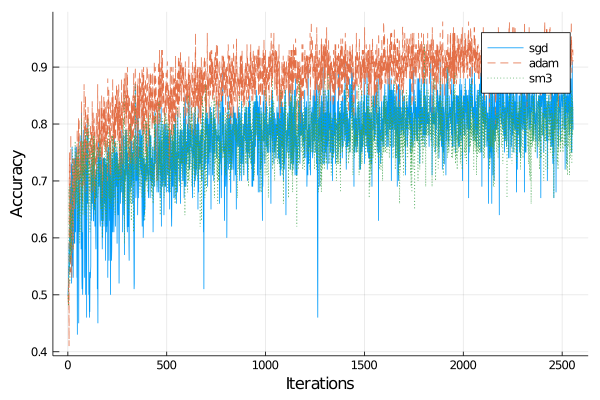

In [63]:
plot([sdg_results["trn_acc_history"], adam_results["trn_acc_history"], sm3_results["trn_acc_history"]],
    labels=[:sgd :adam :sm3],xlabel="Iterations",ylabel="Accuracy")

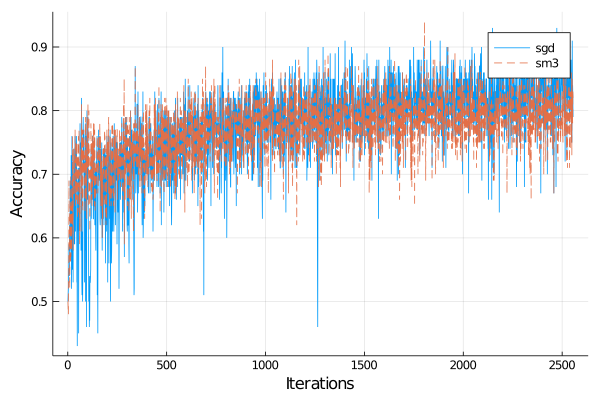

In [71]:
plot([sdg_results["trn_acc_history"], sm3_results["trn_acc_history"]],
    labels=[:sgd :sm3],xlabel="Iterations",ylabel="Accuracy")

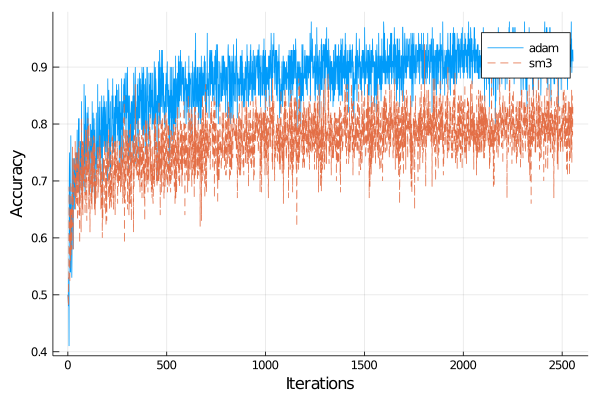

In [77]:
plot([adam_results["trn_acc_history"], sm3_results["trn_acc_history"]],
    labels=[:adam :sm3],xlabel="Iterations",ylabel="Accuracy")

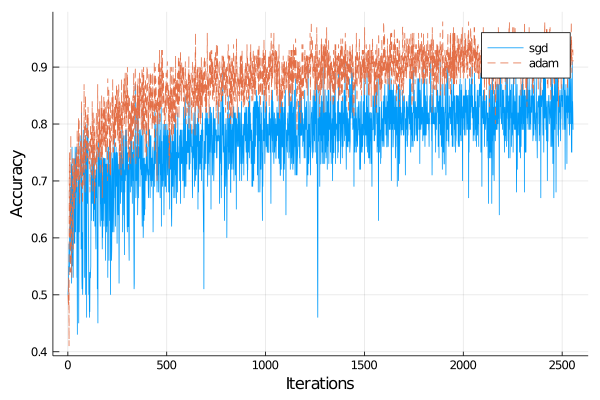

In [76]:
plot([sdg_results["trn_acc_history"], adam_results["trn_acc_history"]],
    labels=[:sgd :adam],xlabel="Iterations",ylabel="Accuracy")

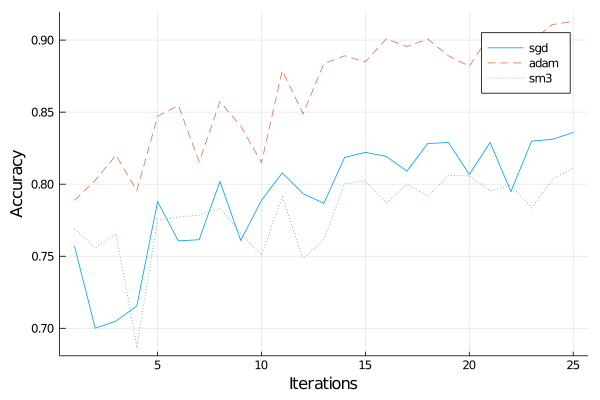

In [65]:
plot([sdg_results["val_acc_history"], adam_results["val_acc_history"], sm3_results["val_acc_history"]],
    labels=[:sgd :adam :sm3],xlabel="Iterations",ylabel="Accuracy")

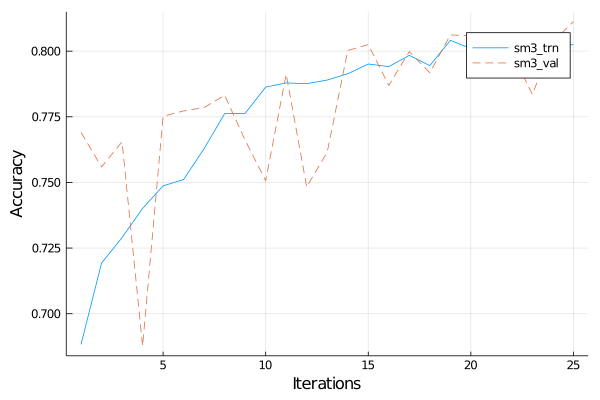

In [111]:
plot([sm3_trn_avg, sm3_results["val_acc_history"]],
    labels=[:sm3_trn :sm3_val],xlabel="Iterations",ylabel="Accuracy")

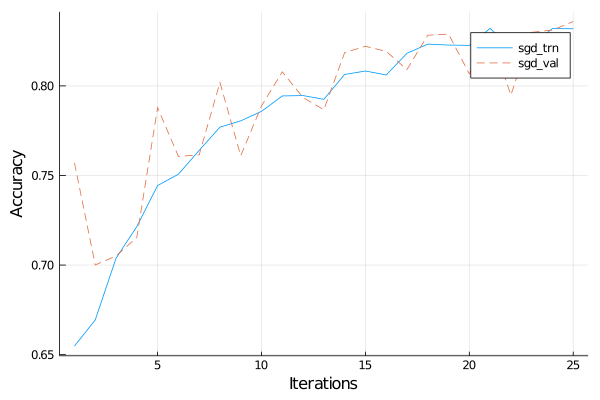

In [110]:
plot([sgd_trn_avg, sdg_results["val_acc_history"]],
    labels=[:sgd_trn :sgd_val],xlabel="Iterations",ylabel="Accuracy")

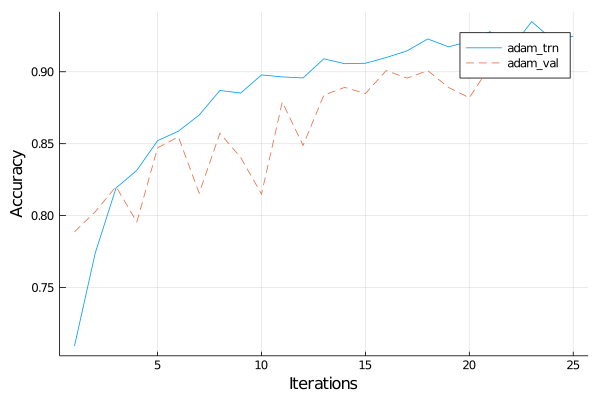

In [109]:
plot([adam_trn_avg, adam_results["val_acc_history"]],
    labels=[:adam_trn :adam_val],xlabel="Iterations",ylabel="Accuracy")